## Including MeSH

In [1]:
MIMIC_Path = '/lustre/home/almusawiaf/PhD_Projects/MIMIC_resources'

In [5]:
'''
generate_HG is class used to generate the 203 heterogeneous graph only.
We only included patients with diagnoses.
'''
import pandas as pd
import networkx as nx
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class Generate_HG:
    
    def __init__(self, folder_path):

        self.folder_path = folder_path
        
        print('Loading the dataframes...')
        
        new_Diagnosis, new_Prescriptions, new_Procedures, new_LabTest, new_MicroBio, new_Symptoms, new_ICUSTAY = self.load_patients_data()
        
        self.newICUSTAY = new_ICUSTAY

        print('Extracting bipartite networks...')
        self.CV = self.get_Bipartite(new_ICUSTAY,   'SUBJECT_ID', 'HADM_ID',     'C', 'V', 'Visits')
        self.VI = self.get_Bipartite(new_ICUSTAY,      'HADM_ID', 'ICUSTAY_ID',  'V', 'I', 'ICU_stays')        
        self.VD = self.get_Bipartite(new_Diagnosis,    'HADM_ID', 'ICD9_CODE',   'V', 'D', 'Diagnosis')
        self.VP = self.get_Bipartite(new_Procedures,   'HADM_ID', 'ICD9_CODE',   'V', 'P', 'Procedures')
        self.VM = self.get_Bipartite(new_Prescriptions,'hadm_id', 'drug',        'V', 'M', 'Medications')
        self.VL = self.get_Bipartite(new_LabTest,      'HADM_ID', 'ITEMID_FLAG', 'V', 'L', 'Lab tests')
        self.VB = self.get_Bipartite(new_MicroBio,     'HADM_ID', 'SPEC_ITEMID', 'V', 'B', 'MicroBiology tests')
        self.VS = self.get_Bipartite(new_Symptoms,     'HADM_ID', 'SYMPTOM',     'V', 'S', 'Mesh Symptoms')

        print('Edges:')
        print(f'\tPatient-Visits edges    :{len(self.CV)}')
        print(f'\tVisits-ICU stays edges  :{len(self.VI)}')
        print(f'\tVisits-Diagnoses edges  :{len(self.VD)}')
        print(f'\tVisits-Medications edges:{len(self.VM)}')
        print(f'\tVisits-Procedures edges :{len(self.VP)}')
        print(f'\tVisits-Lab tests edges  :{len(self.VL)}')
        print(f'\tVisits-MicroBio edges   :{len(self.VB)}')        
        print(f'\tVisits-Symptoms edges   :{len(self.VS)}')        
        
        edges_list = self.CV + self.VD + self.VP + self.VM + self.VB + self.VL + self.VS + self.VI

        self.HG = nx.Graph()
        self.HG.add_edges_from(edges_list)
        self.print_statistics()

        # excluding those visits with multiple ICU stays...
        V_to_delete = self.exclude_multiple_ICU_visits()
        print(f'\n|--- New Visits-ICU stays edges  :{len(self.VI)}\n')        
        self.HG.remove_nodes_from(V_to_delete)
        
        self.selecting_top_labs()       
        self.print_statistics()

        self.remove_isolated_nodes()        
        self.print_statistics()
        
        
    def exclude_multiple_ICU_visits(self):
        G = nx.Graph()
        G.add_edges_from(self.VI)

        # Step 1: Extract V_ nodes
        V_nodes = [node for node in G.nodes if node.startswith("V_")]

        # Step 2: Compute degrees of V_ nodes
        V_degrees = [G.degree(node) for node in V_nodes]
        # self.plotting_distribution_VI(V_degrees)        

        V_to_delete = [node for node in V_nodes if G.degree(node)>1]
        return V_to_delete
    

    def plotting_distribution_VI(self, V_degrees)        :
        plt.figure(figsize=(6,4))
        plt.hist(V_degrees, bins=range(1, max(V_degrees)+2), align='left', edgecolor='black', alpha=0.7)
        plt.xlabel("Degree")
        plt.ylabel("Frequency")
        plt.title("Degree Distribution of Admission-ICUSTAY")
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.show()
        plt.savefig(f'../../Data/admission_ICUSTAY_distribution.png')

        


    def set_nodes(self):
        HG_Nodes = list(self.HG.nodes())
        self.Patients =    [v for v in HG_Nodes if v[0] == 'C']
        self.Visits =      [v for v in HG_Nodes if v[0] == 'V']
        self.Medications = [v for v in HG_Nodes if v[0] == 'M']
        self.Diagnosis  =  [v for v in HG_Nodes if v[0] == 'D']
        self.Procedures =  [v for v in HG_Nodes if v[0] == 'P']
        self.Labs       =  [v for v in HG_Nodes if v[0] == 'L']
        self.MicroBio   =  [v for v in HG_Nodes if v[0] == 'B']
        self.Symptoms   =  [v for v in HG_Nodes if v[0] == 'S']
        self.ICUstays   =  [v for v in HG_Nodes if v[0] == 'I']
        
        self.Nodes = self.Patients + self.Visits + self.Medications + self.Diagnosis + self.Procedures + self.Labs + self.MicroBio + self.Symptoms + self.ICUstays
    
    def set_edges(self):
        self.CV = self.get_edges('C', 'V')
        self.VI = self.get_edges('V', 'I')
        self.VD = self.get_edges('V', 'D')
        self.VP = self.get_edges('V', 'P')
        self.VM = self.get_edges('V', 'M')
        self.VL = self.get_edges('V', 'L')
        self.VB = self.get_edges('V', 'B')
        self.VS = self.get_edges('V', 'S')
        
        
    def get_edges(self, ID1, ID2):
        return [(v, u) for v, u in self.HG.edges() if v[0]==ID1 and u[0]==ID2]
        
        
    
    def print_statistics(self): 
        self.set_nodes()
        self.set_edges()
        print(f'  number of patients = {len(self.Patients)}')
        print(f'    number of visits = {len(self.Visits)}')
        print(f' number of ICU_Stays = {len(self.ICUstays)}')
        print(f'number of Medication = {len(self.Medications)}')
        print(f' number of Diagnoses = {len(self.Diagnosis)}')
        print(f'number of Procedures = {len(self.Procedures)}')
        print(f'      number of Labs = {len(self.Labs)}')
        print(f'   number of MicoBio = {len(self.MicroBio)}')
        print(f'  number of Symptoms = {len(self.Symptoms)}\n')
        
        print(f'number of Edges = {self.HG.number_of_edges()}\n')
        
        print('Edges:')
        print(f'\tPatient-Visits edges    :{len(self.CV)}')
        print(f'\tVisits-ICU stays edges  :{len(self.VI)}')
        print(f'\tVisits-Diagnoses edges  :{len(self.VD)}')
        print(f'\tVisits-Medications edges:{len(self.VM)}')
        print(f'\tVisits-Procedures edges :{len(self.VP)}')
        print(f'\tVisits-Lab tests edges  :{len(self.VL)}')
        print(f'\tVisits-MicroBio edges   :{len(self.VB)}')        
        print(f'\tVisits-Symptoms edges   :{len(self.VS)}\n')    

        
    def get_Bipartite(self, DF, id1, id2, c1, c2, msg):
        '''DF: dataframe, id1: row1, id2: row2, c1, c2: node code'''  
        print(f'Extracting and adding data of {msg}')

        DF2    = self.getDict2(DF,  id1, id2, c1, c2)
        return self.getEdges(DF2, id1, id2)
    
    def split_lab_test(self, lab_df):
        print('Splitting lab tests')
        # Step 1: Fill NaN values in the 'FLAG' column with 'normal'
        lab_df['FLAG'] = lab_df['FLAG'].fillna('normal')
        
        # Step 2: Remove rows where 'FLAG' equals 'delta'
        lab_df = lab_df[lab_df['FLAG'] != 'delta']
        
        # Step 3: Create a new DataFrame with HADM_ID and a concatenated column 'itemid_flag'
        # Concatenate 'ITEMID' and 'FLAG' as strings
        lab_df.loc[:, 'ITEMID_FLAG'] = lab_df['ITEMID'].astype(str) + '_' + lab_df['FLAG'].astype(str)

        
        # Create the new DataFrame with 'HADM_ID' and the concatenated 'itemid_flag' column
        new_df = lab_df[['HADM_ID', 'ITEMID_FLAG']].copy()
        print(f'Number of visits here is {len(new_df["HADM_ID"].unique())}')

        return new_df

    def remove_isolated_nodes(self):
        print('Removing isolated nodes')
        self.set_nodes()
        isolated_nodes = [v for v in self.Nodes if self.HG.degree(v)==0]
        self.HG.remove_nodes_from(isolated_nodes) 


    def extract3(self, code):
        return str(code)[:3]
    
    def extract2(self, code):
        return str(code)[:2]
    
    def load_patients_data(self):
        # Loading the data
        # --------------------------------------------------------------------------------------
        df_admissions = pd.read_csv(f'{self.folder_path}/ADMISSIONS.csv')
        df_admissions.dropna(subset=['SUBJECT_ID','HADM_ID'], inplace=True)
        # dropping visits with expire flag (passed patients)
        df_admissions = df_admissions[df_admissions['HOSPITAL_EXPIRE_FLAG']==0].copy()
        not_expired_admissions = df_admissions['HADM_ID']
        del df_admissions
        
        df_ICUs = pd.read_csv(f'{self.folder_path}/ICUSTAYS.csv')
        df_ICUs = df_ICUs[['SUBJECT_ID','HADM_ID','ICUSTAY_ID','LOS']]
        df_ICUs.dropna(subset=['SUBJECT_ID','HADM_ID','ICUSTAY_ID','LOS'], inplace=True)
        
        # dropping LOS less than a day
        df_ICUs = df_ICUs[df_ICUs['LOS']>=1].copy()
        
        # dropping expired visits from df_ICU
        df_ICUs = df_ICUs[df_ICUs['HADM_ID'].isin(not_expired_admissions)].copy()
        
        visits_ICU = df_ICUs['HADM_ID'].unique()
        patients   = df_ICUs['SUBJECT_ID'].unique()
        ICU_stays  = df_ICUs['ICUSTAY_ID'].unique()
        # --------------------------------------------------------------------------------------
        print(f'ICU Stay info:\nNumber of patients: {len(patients)}\nNumber of visits:{len(visits_ICU)}\nNumber of ICU stays: {len(ICU_stays)}')       
        # --------------------------------------------------------------------------------------
        df_Medications   = pd.read_csv(f'{self.folder_path}/PRESCRIPTIONS.csv')         # Medications!
        df_DiagnosisICD  = pd.read_csv(f'{self.folder_path}/DIAGNOSES_ICD.csv')         # Diagnosis!
        df_ProceduresICD = pd.read_csv(f'{self.folder_path}/PROCEDURES_ICD.csv')        # Procedures!
        df_labs          = pd.read_csv(f'{self.folder_path}/LABEVENTS.csv')             # Lab test!
        df_microbio      = pd.read_csv(f'{self.folder_path}/MICROBIOLOGYEVENTS.csv')    # Microbiology!
        df_symptoms      = pd.read_csv(f'{self.folder_path}/Symptoms.csv')              # Symptoms!
        # ----------------------------------------------------------------------------                
        # Handling missing values upfront (dropping rows with missing important columns)
        df_DiagnosisICD .dropna(subset=['HADM_ID', 'ICD9_CODE'], inplace=True)
        df_ProceduresICD.dropna(subset=['ICD9_CODE'], inplace=True)
        df_Medications  .dropna(subset=['drug'], inplace=True)
        df_labs         .dropna(subset=['HADM_ID', 'ITEMID'], inplace=True)
        df_microbio     .dropna(subset=['ORG_ITEMID'], inplace=True)
        df_symptoms     .dropna(subset=['SYMPTOM'], inplace=True)
        # --------------------------------------------------------------------------------------
        df_labs['HADM_ID'] = df_labs['HADM_ID'].astype(int)
        df_labs = self.split_lab_test(df_labs)        
        # --------------------------------------------------------------------------------------
        # Filtering the data for selected patients and visits
        print('Use the patients inside the new DataFrame....')
        new_Diagnosis  = df_DiagnosisICD[df_DiagnosisICD  ['HADM_ID'].isin(visits_ICU)].copy()
        new_Procedures = df_ProceduresICD[df_ProceduresICD['HADM_ID'].isin(visits_ICU)].copy()
        new_Medication = df_Medications[df_Medications    ['hadm_id'].isin(visits_ICU)].copy()
        new_LabTest    = df_labs[df_labs                  ['HADM_ID'].isin(visits_ICU)].copy()
        new_MicroBio   = df_microbio[df_microbio          ['HADM_ID'].isin(visits_ICU)].copy()
        new_symptoms   = df_symptoms[df_symptoms          ['HADM_ID'].isin(visits_ICU)].copy()
        # ----------------------------------------------------------------------------        
        new_Diagnosis ['ICD9_CODE'] = new_Diagnosis['ICD9_CODE'].apply(self.extract3)
        new_Procedures['ICD9_CODE'] = new_Procedures['ICD9_CODE'].apply(self.extract2)
        # ----------------------------------------------------------------------------        
        diag_frequency = new_Diagnosis['ICD9_CODE'].value_counts().head(203).index.tolist()        
        new_Diagnosis  = new_Diagnosis[new_Diagnosis['ICD9_CODE'].isin(diag_frequency)]                
        # # ----------------------------------------------------------------------------
        return new_Diagnosis, new_Medication, new_Procedures, new_LabTest, new_MicroBio, new_symptoms, df_ICUs



    def selecting_top_labs(self):
        '''Selecting the top 480 connected Lab Nodes...'''
        self.set_nodes()
        # extracting {Lab node: its degree}
        node_degrees = {n: self.HG.degree(n) for n in self.Nodes if n[0] == 'L'} 
        # sorting lab nodes by its degree
        top_nodes = dict(sorted(node_degrees.items(), key=lambda item: item[1], reverse=True)[:480])
        labs_to_delete = [n for n in node_degrees if n not in top_nodes]
        self.HG.remove_nodes_from(labs_to_delete)
            

    def getDict2(self, df, id1, id2, c1, c2):
        # Create a copy of the relevant columns
        new_df = df[[id1, id2]].copy()
        
        # Drop rows with NaN values in either id1 or id2
        new_df = new_df.dropna(subset=[id1, id2])
        
        # Explicitly cast columns to string to avoid dtype compatibility issues
        new_df[id1] = new_df[id1].astype(str)
        new_df[id2] = new_df[id2].astype(str)
        
        # Add the prefixes to each column after ensuring there are no NaNs
        new_df.loc[:, id1] = c1 + '_' + new_df[id1]
        new_df.loc[:, id2] = c2 + '_' + new_df[id2]
        
        # Remove duplicate rows
        new_df = new_df.drop_duplicates()
        
        return new_df

    def getEdges(self, data, id1, id2):
        # Check if data is a DataFrame and extract edges accordingly
        if isinstance(data, pd.DataFrame):
            # Extract edges from the DataFrame
            EdgesList = list(data[[id1, id2]].itertuples(index=False, name=None))
        else:
            # Assuming data is a list of dictionaries
            EdgesList = [(d[id1], d[id2]) for d in data]
        
        return EdgesList


    def get_feature_visit_level(self, the_features, the_id):
        '''based on the list of edges (V-I), we collect the features of the corresponding V. 
        However, the collected features will be sorted by V-I !
        MAKE ATTENTION TO THAT'''
        F = the_features
        F_indeces = {p:k for k,p in enumerate(F)}

        X = []
        for v, i in self.VI:
            f = [0] * len(F)
            for u in self.HG.neighbors(v):
                if u[0] ==the_id:
                    f[F_indeces[u]] = 1
            X.append(f)
        
        return np.array(X)
        
   
    def get_Y_visit_level(self):
        '''return a 3 cols np array of hadm_id, icu stays and LoS as a class.
        You can use the returned array for validation purposes.'''

        Y = []
        for v, i in self.VI:
            V = int(v[2:])
            I = int(i[2:])    
            los_value = self.newICUSTAY.loc[(self.newICUSTAY['HADM_ID'] == V) & (self.newICUSTAY['ICUSTAY_ID'] == I), 'LOS'].iloc[0]
            Y.append([V, I, los_value])        
            
        return np.array(Y)

    def get_Demo(self):      
        '''return the demographic information for the given self.Visits'''
          
        df_admissions = pd.read_csv(f'{MIMIC_Path}/ADMISSIONS_DEMO.csv')

        hadm_ids = [int(item[1].split('_')[1]) for item in self.Visits]  # Extract numeric part of 'V_{hadm_id}'

        # Ensure the filtered DataFrame is ordered based on the hadm_ids list
        df = df_admissions[df_admissions['HADM_ID'].isin(hadm_ids)]
        df = df.set_index('HADM_ID').loc[hadm_ids].reset_index()


        df = df[['GENDER', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'ADMISSION_TYPE', 'INSURANCE']]
        df['GENDER'] = df['GENDER'].replace({'F': 0, 'M': 1})


        df['RELIGION'] = df['RELIGION'].fillna('NOT SPECIFIED')
        df['MARITAL_STATUS'] = df['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')

        cols = ['RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'ADMISSION_TYPE', 'INSURANCE']
        
        # Apply one-hot encoding to the selected columns
        df_one_hot = pd.get_dummies(df, columns=cols)
        df_one_hot = df_one_hot.replace({True: 1, False: 0})

        return df_one_hot.to_numpy()

In [6]:
# Function to save a list as a pickle file
def save_list_as_pickle(L, given_path, file_name):
    import os
    import pickle

    # Create the directory if it doesn't exist
    os.makedirs(given_path, exist_ok=True)
    
    print(f'Saving to {given_path}/{file_name}.pkl')
    with open(f'{given_path}/{file_name}.pkl', 'wb') as file:
        pickle.dump(L, file)


In [7]:
GenHG = Generate_HG(MIMIC_Path)

Loading the dataframes...
ICU Stay info:
Number of patients: 33696
Number of visits:41630
Number of ICU stays: 43810
Splitting lab tests


/tmp/ipykernel_1862230/162403153.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lab_df.loc[:, 'ITEMID_FLAG'] = lab_df['ITEMID'].astype(str) + '_' + lab_df['FLAG'].astype(str)


Number of visits here is 58151
Use the patients inside the new DataFrame....
Extracting bipartite networks...
Extracting and adding data of Visits
Extracting and adding data of ICU_stays
Extracting and adding data of Diagnosis
Extracting and adding data of Procedures
Extracting and adding data of Medications
Extracting and adding data of Lab tests
Extracting and adding data of MicroBiology tests
Extracting and adding data of Mesh Symptoms
Edges:
	Patient-Visits edges    :41630
	Visits-ICU stays edges  :43810
	Visits-Diagnoses edges  :400208
	Visits-Medications edges:2746
	Visits-Procedures edges :128638
	Visits-Lab tests edges  :3414440
	Visits-MicroBio edges   :27641
	Visits-Symptoms edges   :583143
  number of patients = 33696
    number of visits = 41630
 number of ICU_Stays = 43810
number of Medication = 478
 number of Diagnoses = 203
number of Procedures = 89
      number of Labs = 975
   number of MicoBio = 62
  number of Symptoms = 512

number of Edges = 4642256

Edges:
	Patient

In [12]:
saving_path = '../Data/structured/ALL2'

X_D = GenHG.get_feature_visit_level(GenHG.Diagnosis,  'D')
X_P = GenHG.get_feature_visit_level(GenHG.Procedures, 'P')
X_M = GenHG.get_feature_visit_level(GenHG.Medications,'M')
X_L = GenHG.get_feature_visit_level(GenHG.Labs,       'L')
X_B = GenHG.get_feature_visit_level(GenHG.MicroBio,   'B')
X_S = GenHG.get_feature_visit_level(GenHG.Symptoms,   'S')

Y   = GenHG.get_Y_visit_level()

save_list_as_pickle(X_D, f'{saving_path}', 'X_D')
save_list_as_pickle(X_P, f'{saving_path}', 'X_P')
save_list_as_pickle(X_M, f'{saving_path}', 'X_M')
save_list_as_pickle(X_L, f'{saving_path}', 'X_L')
save_list_as_pickle(X_B, f'{saving_path}', 'X_B')
save_list_as_pickle(X_S, f'{saving_path}', 'X_S')

save_list_as_pickle(Y, f'{saving_path}', 'VIY')

# saving the list of properties
save_list_as_pickle([i[2:] for i in GenHG.Diagnosis],   f'{saving_path}', 'D')
save_list_as_pickle([i[2:] for i in GenHG.Procedures],  f'{saving_path}', 'P')
save_list_as_pickle([i[2:] for i in GenHG.Medications], f'{saving_path}', 'M')
save_list_as_pickle([i[2:] for i in GenHG.Labs],        f'{saving_path}', 'L')
save_list_as_pickle([i[2:] for i in GenHG.MicroBio],    f'{saving_path}', 'B')
save_list_as_pickle([i[2:] for i in GenHG.Symptoms],    f'{saving_path}', 'S')

Saving to ../Data/structured/ALL2/X_D.pkl
Saving to ../Data/structured/ALL2/X_P.pkl
Saving to ../Data/structured/ALL2/X_M.pkl
Saving to ../Data/structured/ALL2/X_L.pkl
Saving to ../Data/structured/ALL2/X_B.pkl
Saving to ../Data/structured/ALL2/X_S.pkl
Saving to ../Data/structured/ALL2/VIY.pkl
Saving to ../Data/structured/ALL2/D.pkl
Saving to ../Data/structured/ALL2/P.pkl
Saving to ../Data/structured/ALL2/M.pkl
Saving to ../Data/structured/ALL2/L.pkl
Saving to ../Data/structured/ALL2/B.pkl
Saving to ../Data/structured/ALL2/S.pkl


In [13]:
X_D.shape, X_P.shape, X_M.shape, X_L.shape, X_B.shape, X_S.shape, X_D.shape, Y.shape

((39697, 203),
 (39697, 89),
 (39697, 477),
 (39697, 480),
 (39697, 62),
 (39697, 509),
 (39697, 203),
 (39697, 3))

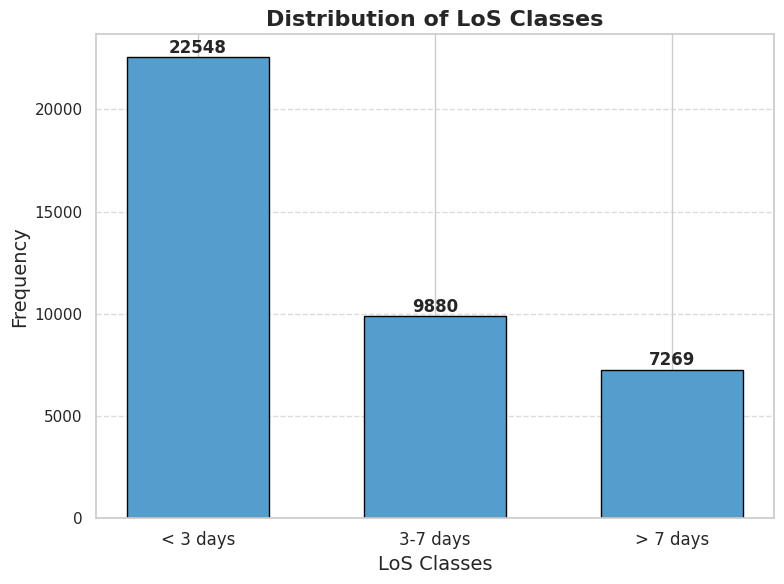

In [14]:
# Step 1: Categorize LoS into classes
bins = [0, 3, 7, np.inf]  # Define the class boundaries
labels = ['< 3 days', '3-7 days', '> 7 days']  # Class labels
Y_classes = pd.cut(Y[:,2], bins=bins, labels=labels, right=False)  # Assign class labels

# Step 2: Count occurrences of each class
class_counts = Y_classes.value_counts()

# Step 3: Create a professional bar plot
# Set the style using Seaborn for cleaner aesthetics
sns.set(style="whitegrid")

# Create the plot with professional styling
plt.figure(figsize=(8, 6))

# Plot the bars with specific styling
bars = plt.bar(class_counts.index, class_counts.values, color=sns.color_palette("Blues")[3], edgecolor='black', width=0.6)

# Add counts on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 10, round(yval), ha='center', va='bottom', fontsize=12, fontweight='bold')

# Add title and axis labels with professional fonts
plt.title('Distribution of LoS Classes', fontsize=16, fontweight='bold')
plt.xlabel('LoS Classes', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Customize grid lines (lighter and less intrusive)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Improve x-axis labels' readability
plt.xticks(rotation=0, fontsize=12)

# Tight layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


In [15]:
Y[:,0]

array([106296., 188028., 173727., ..., 123750., 118475., 156386.])